### Title: Analyzing Metadata of Hugging Face Models

#### Introduction
 Hugging Face provides a wide variety of machine learning models that can be used in diverse domains. In this notebook, we analyze metadata of models available on Hugging Face Hub. Specifically, we retrieve metadata such as download counts, parameters, release dates, and licenses, and organize the data for insights.

#### Required Libraries
 We use the following libraries for data manipulation and API interaction:

  * `huggingface_hub` for accessing the Hugging Face Hub API.
  * `pandas` for data organization.
  * `matplotlib` for visualization.

In [42]:
import os
import re
import requests
import pandas as pd
from dotenv import load_dotenv
from huggingface_hub import HfApi
import logging
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone

### Step 1: Initialize the Hugging Face API
 The HfApi class is used to interact with the Hugging Face Hub API.

In [36]:
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)
# Load environment variables
load_dotenv()
hf_token = os.getenv("HF_TOKEN")
if hf_token is None:
    raise ValueError("HF_TOKEN not found. Please set it in .env or environment variables.")

# Initialize the Hugging Face API
api = HfApi(token=hf_token)

### Step 2: Fetch Model Metadata
 We retrieve metadata for a large number of public models hosted on Hugging Face. 

In [29]:
try:
    models_gen = api.list_models(full=False)
    models_list = list(models_gen)
    print(f"Found {len(models_list)} model references.")
except Exception as e:
    print(f"Error fetching models: {e}")
    models_list = []

Found 1335549 model references.


### Step 3: Define Metadata Extraction Rules
 We define utility functions to fetch and parse metadata.

In [24]:
def get_model_json(model_id: str, hf_token: str) -> dict:
    """
    Fetch metadata for a specific model from the Hugging Face Hub API.
    """
    url = f"https://huggingface.co/api/models/{model_id}"
    headers = {"Authorization": f"Bearer {hf_token}"} if hf_token else {}
    resp = requests.get(url, headers=headers)
    resp.raise_for_status()
    return resp.json()

def extract_safetensors_params(model_json: dict, model_id: str) -> str:
    """
    Extract safetensors parameters in billions from metadata, or parse from model_id if not found.
    """
    safetensors = model_json.get("safetensors", {})
    total = safetensors.get("total", 0)
    if total > 0:
        return f"{total / 1e9:.3f}B"

    # Attempt to extract from model_id if not in metadata
    match = re.search(r"(\d+\.?\d*)([mMbB])", model_id)
    if match:
        value, unit = match.groups()
        if unit.lower() == "m":
            return f"{float(value) / 1000:.3f}B"
        elif unit.lower() == "b":
            return f"{float(value):.3f}B"

    return "Unknown"

### Step 4: Process Models to Extract Metadata
 We extract metadata for each model, filtering out those with zero downloads.

In [ ]:
results = []
for m in models_list:
    model_id = m.modelId
    try:
        model_info = api.model_info(model_id)
        downloads = model_info.downloads

        if downloads > 0:
        
            model_data = get_model_json(model_id, hf_token)

            safetensors_b_str = extract_safetensors_params(model_data, model_id)
            downloads = model_data.get("downloads", 0) / 1_000_000
            license_ = model_data.get("cardData", {}).get("license", "Unknown")
            last_modified = model_data.get("lastModified", "Unknown")
            author = model_data.get("author", "Unknown")
            tags = model_data.get("tags", [])
            pipeline_tag = model_data.get("pipeline_tag", "Unknown")

            row = {
                "model_id": model_id,
                "downloads (M)": downloads,
                "parameters (B)": safetensors_b_str,
                "last_updated": last_modified,
                "license": license_,
                "author": author,
                "tags": ", ".join(tags),
                "pipeline_tag": pipeline_tag,
            }
            results.append(row)
    except Exception as e:
        results.append({
            "model_id": model_id,
            "downloads (M)": 0,
            "parameters (B)": "Unknown",
            "last_updated": "Unknown",
            "license": "Unknown",
            "author": "Unknown",
            "tags": "Unknown",
            "pipeline_tag": "Unknown",
        })

### Step 5: Organize Metadata into a DataFrame
 The metadata is converted into a pandas DataFrame and sorted descending by downloads. 

In [ ]:
df = pd.DataFrame(results)
df = df.sort_values(by="downloads (M)", ascending=False)
df.reset_index(drop=True, inplace=True)

1321286

DataFrame created with 1321286 entries.
DataFrame columns: ['model_id', 'downloads (M)', 'parameters', 'last_updated', 'license']


The metadata is saved into a .csv file for further analysis.

In [40]:
# Display the top models by downloads
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(df.head(10)["model_id"].to_string())

# Save to CSV
csv_filename = "huggingface_model_metadatá.csv"
df.to_csv(csv_filename, index=False)

1                google-bert/bert-base-uncased
2       sentence-transformers/all-MiniLM-L6-v2
3                        openai-community/gpt2
4             pyannote/speaker-diarization-3.1
5             meta-llama/Llama-3.1-8B-Instruct
6                      openai/whisper-large-v3
7                  answerdotai/ModernBERT-base
8     meta-llama/Llama-3.2-11B-Vision-Instruct
9           mistralai/Mistral-7B-Instruct-v0.3
10               openai/whisper-large-v3-turbo


### Step 6: Visualize Data
 We generate scatter plots to visualize downloads vs. parameters, with zoomed-in regions.

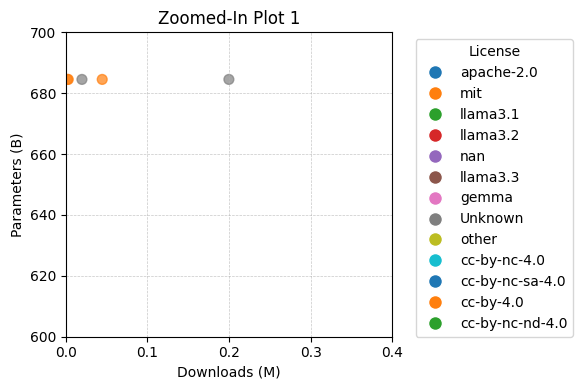

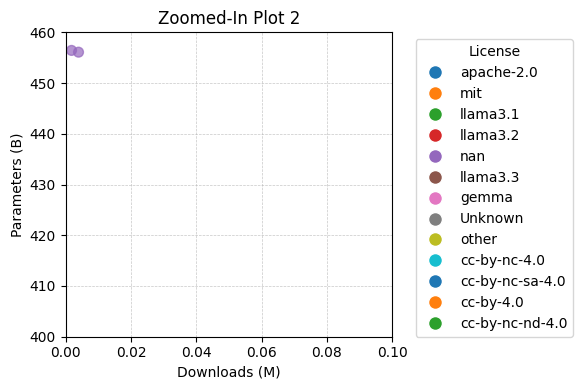

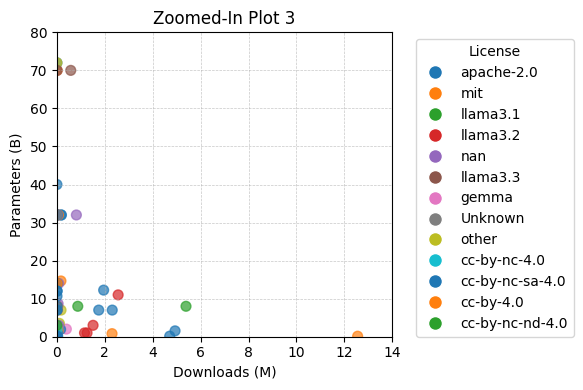

In [43]:
# Load the CSV file
file_path = "/Users/Andreea/KlusAI/TinyFabulist/tiny-fabulist-1/notebooks/huggingface_model_metadata.csv"  # Replace with your actual CSV file path
df = pd.read_csv(file_path)

# Filter for models updated in the last 12 months
current_date = datetime.now()

# Convert last_updated to datetime, coercing errors to NaT
df["last_updated"] = pd.to_datetime(df["last_updated"], errors="coerce")

# Make one_year_ago timezone-aware using UTC
one_year_ago = current_date - timedelta(days=365)
one_year_ago = one_year_ago.replace(tzinfo=timezone.utc)

# Filter rows with valid last_updated and updated within the last 12 months
df_recent = df[(df["last_updated"] >= one_year_ago) & (df["last_updated"].notna())]

# Remove rows where "parameters (B)" is "Unknown" or NaN
df_recent = df_recent[df_recent["parameters (B)"].notna() & (df_recent["parameters (B)"] != "Unknown")]
df_recent["parameters (B)"] = pd.to_numeric(df_recent["parameters (B)"], errors="coerce")

# Filter only the first 95 models
df_recent = df_recent.head(95)

# Create a mapping for license colors
licenses = df_recent["license"].unique()
color_mapping = {license_: f"C{i}" for i, license_ in enumerate(licenses)}
df_recent["color"] = df_recent["license"].map(color_mapping)

# Define zoom ranges for each plot
zoom_regions = [
    {"xlim": (0, 0.4), "ylim": (600, 700)},  # Zoom for the first region
    {"xlim": (0, 0.10), "ylim": (400, 460)},  # Zoom for the second region
    {"xlim": (0, 14), "ylim": (0, 80)},   # Zoom for the dense lower region
]

# Generate plots for each zoom region with fixes for point cropping
for i, region in enumerate(zoom_regions, 1):
    plt.figure(figsize=(6, 4))  # Smaller figure size
    plt.scatter(
        df_recent["downloads (M)"],
        df_recent["parameters (B)"],
        c=df_recent["color"],
        alpha=0.7,
        s=50,  # Increase point size
        # Removed edgecolors to avoid cropping
    )
    plt.xlim(region["xlim"])
    plt.ylim(region["ylim"])

    # Add small margins to avoid cutting points
    plt.margins(x=0.1, y=0.1)

    # Add labels, grid, and title
    plt.xlabel("Downloads (M)")
    plt.ylabel("Parameters (B)")
    plt.title(f"Zoomed-In Plot {i}")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    # Add legend (outside the plot)
    legend_elements = [
        plt.Line2D(
            [0], [0],
            marker="o",
            color="w",
            label=license_,
            markerfacecolor=color_mapping[license_],
            markersize=10
        )
        for license_ in licenses
    ]
    plt.legend(
        handles=legend_elements,
        title="License",
        loc="upper left",
        bbox_to_anchor=(1.05, 1),
    )

    # Adjust layout to avoid overlaps
    plt.tight_layout()

    # Show the plot
    plt.show()
